In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

In [2]:
device = 'cuda'

data_mean = np.full(3, .5)
data_std = np.full(3, .25)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: Image.fromarray(
    invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()
    .multiply(255).type(torch.uint8).numpy())

[0.5 0.5 0.5] [0.25 0.25 0.25]


In [3]:
frames_path = 'datasets/jams-germs/frames/Earthworm Under Microscope'
frame_count = len(os.listdir(frames_path))
sample_size = 32
img_shape = (3, sample_size, sample_size)

In [4]:
def get_batch(batch_size=32):
    comp = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(512), # images are 910x512
        transforms.Resize(sample_size)
    ])
    
    batch = torch.empty(batch_size, *img_shape, device=device)
    for i in range(batch_size):
        frame = np.random.randint(frame_count)
        img = Image.open(f'{frames_path}/{frame}.jpg')
        batch[i] = norm_t(comp(img))
    
    return batch

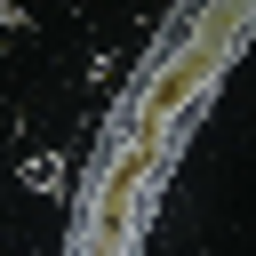

In [5]:
sample_image = get_batch()[0]
tensor_to_img(sample_image).resize((256, 256))

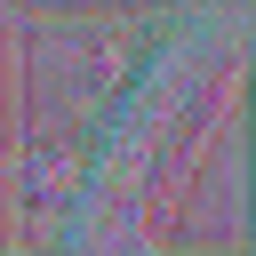

In [6]:
model = UNet2DModel(
    sample_size=sample_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
      ),
).to(device)

tensor_to_img(model(sample_image[None], timestep=0)['sample'][0]).resize((256, 256))

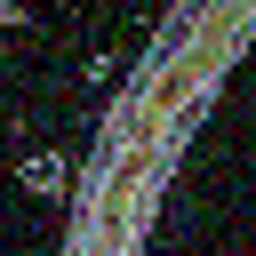

In [7]:
noise_scheduler = DDIMScheduler()

noise = torch.randn(img_shape, device=device)
timesteps = torch.tensor([100], dtype=torch.long, device=device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
tensor_to_img(noisy_image).resize((256, 256))

In [8]:
num_training_steps = int(1e3)

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
losses = []

In [9]:
for i in tqdm(range(num_training_steps)):
    x0 = get_batch()
    noise = torch.randn_like(x0)
    timesteps = torch.randint(noise_scheduler.num_train_timesteps, (x0.shape[0],),
                              dtype=torch.long, device=device)
    xt = noise_scheduler.add_noise(x0, noise, timesteps)
    
    noise_pred = model(xt, timesteps)['sample']
    loss = F.mse_loss(noise_pred, noise)
    losses.append(loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    lr_scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:59<00:00,  2.38it/s]


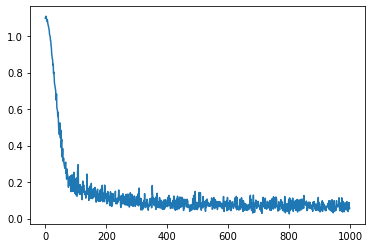

In [10]:
plt.plot(losses)

In [11]:
# sample
with torch.no_grad():
    noise_scheduler.set_timesteps(num_inference_steps=1000)
    xt = torch.randn(16, *img_shape, device=device)
    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = model(xt, t)['sample']
        xt = noise_scheduler.step(noise_pred, t, xt)['prev_sample']

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.25it/s]


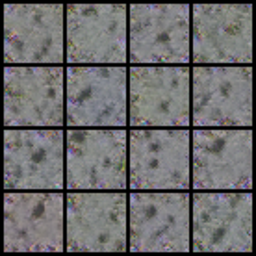

In [12]:
grid = torchvision.utils.make_grid(xt, nrow=4, pad_value=-2)
tensor_to_img(grid).resize((256, 256))